# Title

In this notebook, BLAH BLAH BLAH.


First, the required libraries and data are imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

In [2]:
df = pd.read_csv("data/AB_NYC_2019.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Explore the data to find the count of observations and distribution of values for each variable.

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Some of these columns are irrelevant to the number of reviews being posted. For example, there's no mechanism by which id, host_name, and host_id could impact the number of reviews. The IDs are identifiers used to track the listings in other data sets (for example, AirBnb likely has data sets of reviews and host details). 

There may be information within the 'Name' column that could influence the number of reviews - for example, the name may list amenities such as a hot tub or garden that would make the listing more likely to be booked and then reviewed.

Since 

In [188]:
# for now:

df = df.drop(columns = ['id', 'host_id', 'host_name', 'last_review'])

df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


## Handling missing values

In [189]:
# examine missing values

df.isna().sum()

name                                 16
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [190]:
df[df['reviews_per_month'].isna()]['number_of_reviews'].unique()

array([0], dtype=int64)

Missing values in the 'reviews per month' column arise from the number of reviews being 0. These can be replaced with zero as if there are no reviews at all then the number of reviews per month must also be zero.

In [191]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df.isna().sum()

name                              16
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

Since only 16 rows have missing names out of more than 48000 observations, we can safely drop them.

In [192]:
df.dropna(axis = 0, inplace = True)
df.isna().sum()

name                              0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

## EDA
Before finding out what factors influence the number of monthly reviews, we should explore and visualise the data a little further.

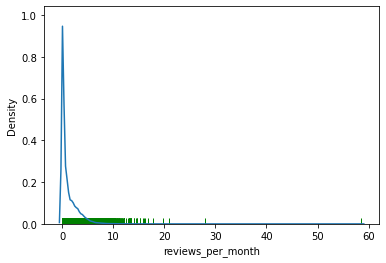

In [193]:
sns.kdeplot(data = df, x = 'reviews_per_month')
sns.rugplot(data = df, x = 'reviews_per_month', color = 'g');

58+ reviews per month sounds very excessive. Something must be going wrong for there to be more monthly reviews than days.

In [194]:
df[df['reviews_per_month']>30]

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
42075,Enjoy great views of the City in our Deluxe Room!,Manhattan,Theater District,40.75918,-73.98801,Private room,100,1,156,58.5,9,299


In [195]:
# check that this is unusual even for listings with a high number of total reviews.
df[df['number_of_reviews']>150]

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
7,Large Furnished Room Near B'way,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,3.47,1,220
9,Cute & Cozy Lower East Side 1 bdrm,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,1.33,4,188
11,Central Manhattan/near Broadway,Manhattan,Hell's Kitchen,40.76076,-73.98867,Private room,85,2,188,1.50,1,39
12,"Lovely Room 1, Garden, Best Area, Legal rental",Brooklyn,South Slope,40.66829,-73.98779,Private room,89,4,167,1.34,3,314
...,...,...,...,...,...,...,...,...,...,...,...,...
28801,Private Room B In Prime Location,Manhattan,Chelsea,40.74729,-73.98957,Private room,115,1,162,8.68,3,312
29280,Amazing Master Bedroom in Historic Brooklyn,Brooklyn,Prospect Heights,40.67757,-73.97023,Private room,35,1,204,11.17,1,19
29628,JFK 3 Comfort 5 Mins from JFK Private Bedroom,Queens,Springfield Gardens,40.66298,-73.77000,Private room,50,1,302,16.81,3,26
30478,♥Private Master Bath | Express Train+Free Park...,Brooklyn,East New York,40.67563,-73.87866,Entire home/apt,86,1,154,9.53,2,311


I think we are safe to drop this outlier as it looks like a mistake. Other listings with 150+ reviews have far fewer monthly reviews. Perhaps this particular listing has been on the website for a shorter time, but with a minimum stay of one night it can't have more reviews than days.

In [196]:
df.drop(df[df['reviews_per_month']>30].index, inplace = True)

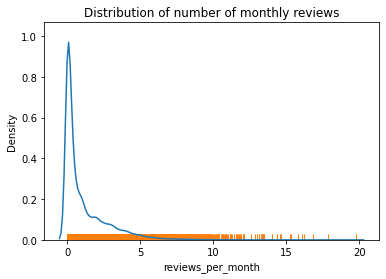

In [197]:
# for the purposes of visualisation we will also ignore the higher numbers for now.
sns.kdeplot(data = df[df['reviews_per_month']<20], 
                   x = 'reviews_per_month')
sns.rugplot(data = df[df['reviews_per_month']<20], 
                   x = 'reviews_per_month')
plt.title("Distribution of number of monthly reviews");

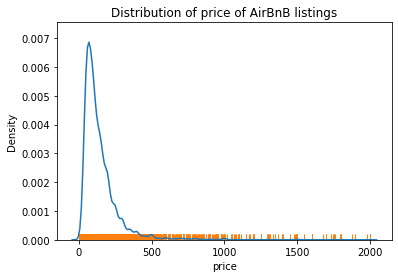

In [198]:
# Now examine distributions of numeric features, e.g. price

sns.kdeplot(data = df[df['price']<2000], # ignore the outliers for visualisation
            x = 'price')
sns.rugplot(data = df[df['price']<2000], # ignore the outliers for visualisation
            x = 'price')
plt.title("Distribution of price of AirBnB listings");

Text(0.5, 1.0, 'Distribution of availability of AirBnB listings (days out of 365)')

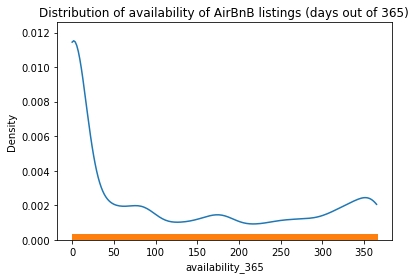

In [199]:
df_vis = df[(df['price']<=2000)&(df['reviews_per_month']<=30)]

sns.kdeplot(data = df_vis, x = 'availability_365', clip = (0,365))
sns.rugplot(data = df_vis, x = 'availability_365')
ax
plt.title("Distribution of availability of AirBnB listings (days out of 365)")

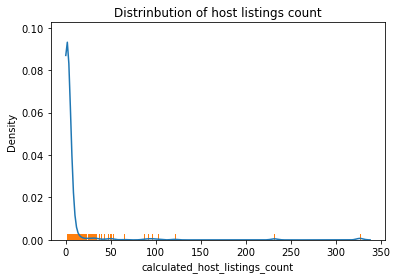

In [200]:
sns.kdeplot(data = df_vis, x = 'calculated_host_listings_count', clip = (0, 500))
sns.rugplot(data = df_vis, x = 'calculated_host_listings_count')
plt.title("Distrinbution of host listings count");

In [201]:
df[df['calculated_host_listings_count']>150].groupby('calculated_host_listings_count')['name'].count()

calculated_host_listings_count
232    232
327    327
Name: name, dtype: int64

There are two hosts with very large numbers of listings (232 and 327). Temporarily omit any properties of hosts that have > 40 properties just to observe the spread.

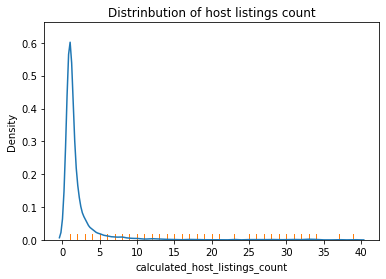

In [202]:
df_vis = df_vis[df_vis['calculated_host_listings_count']<=40]
sns.kdeplot(data = df_vis,x = 'calculated_host_listings_count')
sns.rugplot(data = df_vis,x = 'calculated_host_listings_count')
plt.title("Distrinbution of host listings count");

Given how few listings belong to hosts with more than one listing, it might make more sense to replace with listing with a 0/1 option (1 or more listings). I will add this feature now to consider later.

In [203]:
df['multiple_host_listings'] = df['calculated_host_listings_count'].apply(lambda count: 1 if count > 1 else 0)
df['multiple_host_listings'].value_counts()

0    32289
1    16589
Name: multiple_host_listings, dtype: int64

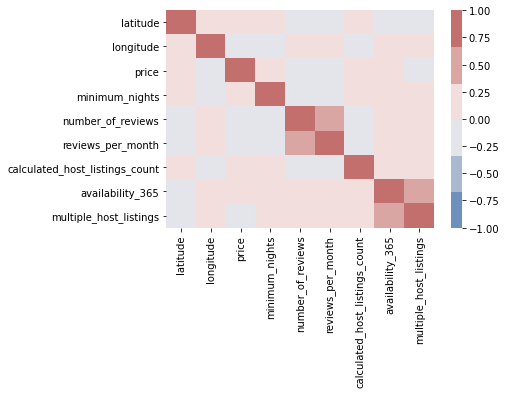

In [204]:
corr = df.corr()

ax = sns.heatmap(corr, 
                 vmin = -1, vmax = 1, center = 0,
                 cmap = sns.color_palette("vlag"))

There is almost no correlation between the numerical features. Next we will consider the neighbourhoods and their effect on the distribution of monthly reviews.

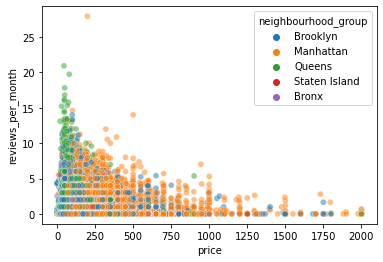

In [205]:
sns.scatterplot(data = df_vis, x = 'price', y = 'reviews_per_month', hue = 'neighbourhood_group', alpha = 0.5);

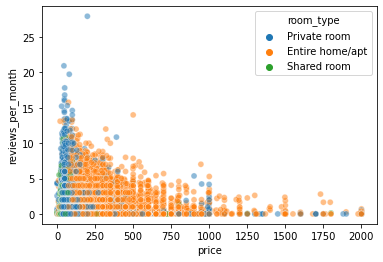

In [206]:
sns.scatterplot(data = df_vis, x = 'price', y = 'reviews_per_month', hue = 'room_type', alpha = 0.5);

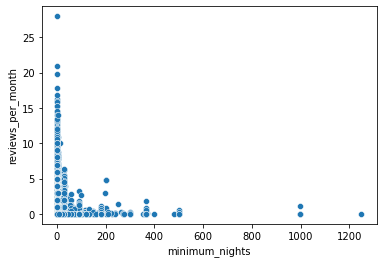

In [207]:
sns.scatterplot(x = 'minimum_nights', y = 'reviews_per_month', data = df_vis);

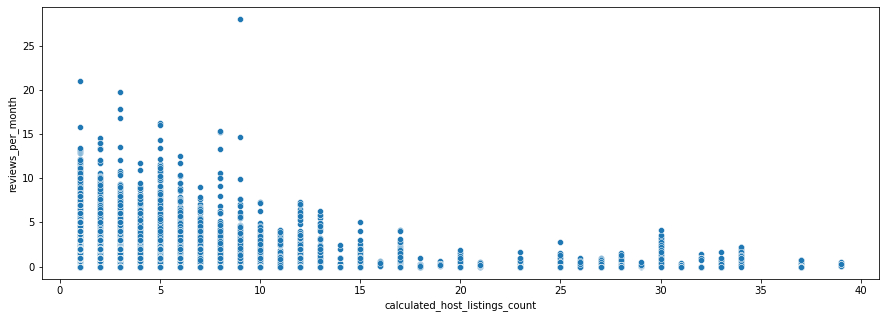

In [208]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.scatterplot(data=df_vis, x = 'calculated_host_listings_count', y = 'reviews_per_month');

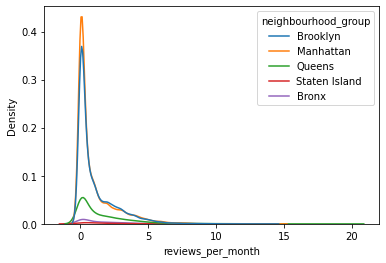

In [209]:
sns.kdeplot(data = df[df['reviews_per_month']<20], x = 'reviews_per_month', hue = 'neighbourhood_group', alpha = 0.8);

## Feature engineering

In [210]:
neighbourhood_groups = pd.get_dummies(df['neighbourhood_group'])
df[neighbourhood_groups.columns] = neighbourhood_groups
#df.drop(columns= ['neighbourhood_group'], inplace = True)
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,multiple_host_listings,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,1,0,1,0,0,0
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,1,0,0,1,0,0
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0,0,0,1,0,0
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0,0,1,0,0,0
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,0,0,0,1,0,0


In [211]:
room_types = pd.get_dummies(df['room_type'])
df[room_types.columns] = room_types
#df.drop(columns = ['room_type'], inplace = True)
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,...,availability_365,multiple_host_listings,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,...,365,1,0,1,0,0,0,0,1,0
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,...,355,1,0,0,1,0,0,1,0,0
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,...,365,0,0,0,1,0,0,0,1,0
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,...,194,0,0,1,0,0,0,1,0,0
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,...,0,0,0,0,1,0,0,1,0,0


In [212]:
# we actually don't need all of the neighbourhood groups and all of the room types - 
#     - if an observation is not entire home/apt and is not private room then we can infer it is a shared room

df.drop(columns = ['Staten Island', 'Shared room'], inplace = True)

In [213]:
df.columns

Index(['name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'multiple_host_listings', 'Bronx', 'Brooklyn',
       'Manhattan', 'Queens', 'Entire home/apt', 'Private room'],
      dtype='object')

## Converting number of monthly reviews to boolean value

Given the shape of the distribution of reviews per month (above), it seems more sensible to attempt to classify listings as "listings with reviews" and "listings without reviews".

In [214]:
# we introduce a 'has_reviews' column to show whether or not there *are* any reviews.
df['has_reviews'] = df['reviews_per_month'].apply(lambda count: 0 if count == 0 else 1)
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,multiple_host_listings,Bronx,Brooklyn,Manhattan,Queens,Entire home/apt,Private room,has_reviews
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,1,0,1,0,0,0,1,1
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,1,0,0,1,0,1,0,1
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0,0,0,1,0,0,1,0
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0,0,1,0,0,1,0,1
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,0,0,0,1,0,1,0,1


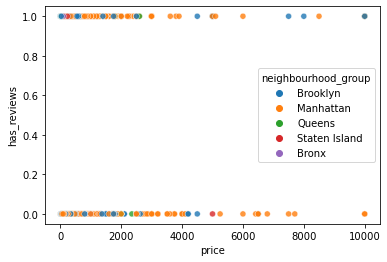

In [215]:
sns.scatterplot(data = df, x = 'price', hue = 'neighbourhood_group', y = 'has_reviews', alpha = 0.8);

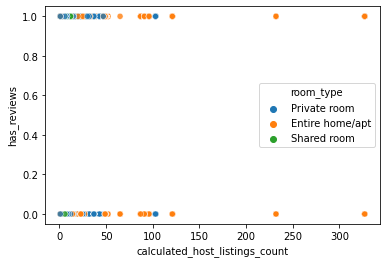

In [216]:
sns.scatterplot(data = df, x = 'calculated_host_listings_count', hue = 'room_type', y = 'has_reviews', alpha = 0.8);

In [217]:
# we're going to work with a smaller number of these columns

airbnb_features = df.drop(columns = ['name','neighbourhood_group', 'room_type', 'neighbourhood', 'number_of_reviews', 'calculated_host_listings_count'])
airbnb_features.head()

,latitude,longitude,price,minimum_nights,reviews_per_month,availability_365,multiple_host_listings,Bronx,Brooklyn,Manhattan,Queens,Entire home/apt,Private room,has_reviews
0,40.64749,-73.97237,149,1,0.21,365,1,0,1,0,0,0,1,1
1,40.75362,-73.98377,225,1,0.38,355,1,0,0,1,0,1,0,1
2,40.80902,-73.94190,150,3,0.00,365,0,0,0,1,0,0,1,0
3,40.68514,-73.95976,89,1,4.64,194,0,0,1,0,0,1,0,1
4,40.79851,-73.94399,80,10,0.10,0,0,0,0,1,0,1,0,1


As demonstrated in the visualisations above, price, reviews_per_month, availability_365 are not normally distributed. They are all also on vastly different scales, so they should be normalised. Because there are outliers in all of these features, a `RobustScaler()` should be used rather than a min-max scaler.

In [218]:
from sklearn.preprocessing import RobustScaler

# create robust scaler object
scaler = RobustScaler()

# fit and transform the data with the robust scaler
airbnb_scaled = pd.DataFrame(scaler.fit_transform(X = airbnb_features), columns = airbnb_features.columns)
airbnb_scaled.head()

,latitude,longitude,price,minimum_nights,reviews_per_month,availability_365,multiple_host_listings,Bronx,Brooklyn,Manhattan,Queens,Entire home/apt,Private room,has_reviews
0,-1.035127,-0.356700,0.405660,-0.50,-0.103896,1.409692,1.0,0.0,1.0,0.0,0.0,-1.0,1.0,0.0
1,0.418310,-0.600342,1.122642,-0.50,0.006494,1.365639,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.177006,0.294507,0.415094,0.00,-0.240260,1.409692,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,-1.0
3,-0.519515,-0.087198,-0.160377,-0.50,2.772727,0.656388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.033073,0.249840,-0.245283,1.75,-0.175325,-0.198238,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [219]:
airbnb_scaled['has_reviews'].value_counts()

 0.0    38836
-1.0    10042
Name: has_reviews, dtype: int64

The robust scaler has shifted the variables with 0 or 1 values so that 0 becomes -1 and 1 becomes 0.

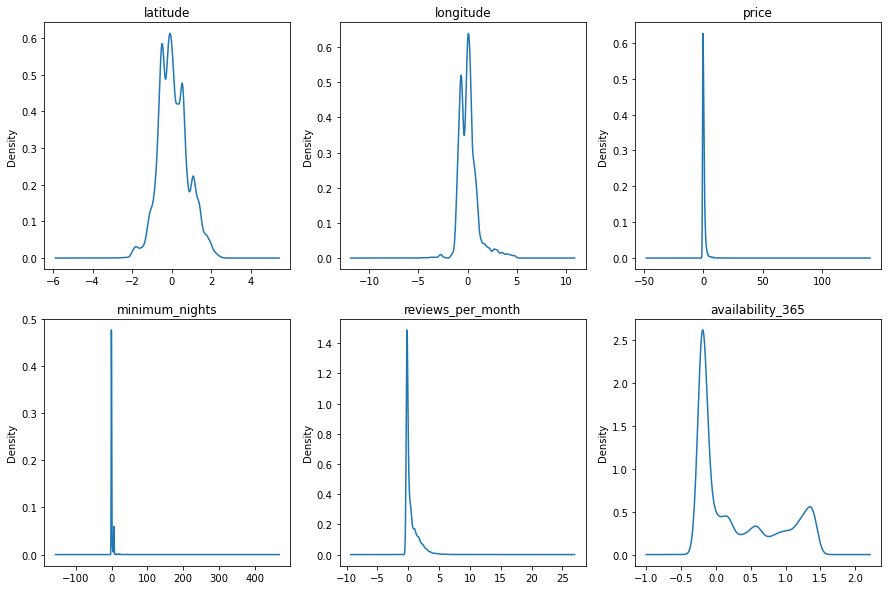

In [220]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(ncols = 3, nrows = 2, figsize = (15, 10), sharey = False)

for col, ax in zip(airbnb_scaled.columns.tolist()[:6], [ax1, ax2, ax3, ax4, ax5, ax6]):
    airbnb_scaled[col].plot.density(ax = ax, title = col)

In [221]:
# convert our target variable to integer

airbnb_scaled['has_reviews'] = airbnb_scaled['has_reviews'].astype('int')

## What factors influence whether or not a listing has received reviews?


In [222]:
X = airbnb_scaled.drop(columns = ['reviews_per_month', 'has_reviews']).values
X[:2]

array([[-1.03512736, -0.35670015,  0.40566038, -0.5       ,  1.40969163,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -1.        ,  1.        ],
       [ 0.41831005, -0.60034195,  1.12264151, -0.5       ,  1.36563877,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ]])

In [223]:
y = airbnb_scaled['has_reviews'].values
y[:10]

array([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0])

### Split the data into training and test datasets

In [224]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4, stratify = y)
X_test[:4]

array([[-1.72370583,  0.08954905, -0.52830189,  6.75      , -0.19823789,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.51307861,  0.53066895, -0.60377358,  6.75      ,  1.17180617,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -1.        ,  1.        ],
       [ 0.50171186,  1.91515281, -0.1509434 , -0.25      ,  0.39647577,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ],
       [-0.03704465, -0.83051934,  0.68867925, -0.25      ,  1.17180617,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ]])

In [225]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
type(y_pred)

numpy.ndarray

[[0.38595618 0.61404382]
 [0.16361998 0.83638002]]


<ipython-input-226-b5d55199f742>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-226-b5d55199f742>:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



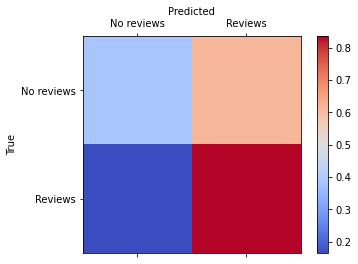

In [226]:
from sklearn.metrics import confusion_matrix
from typing import List

def plot_confusion_matrix(labels: List[int], tick_labels: List[str], y_test: np.ndarray, y_pred: np.ndarray, normalise = True):
    labels = [-1, 0]
    tick_labels = ["No reviews", "Reviews"]
    conf_matrix = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
    print(conf_matrix)
    # Plotting the confusion matrix with color scale.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_matrix, cmap="coolwarm")
    fig.colorbar(cax)
    ax.set_xticklabels([''] + tick_labels)
    ax.set_yticklabels([''] + tick_labels)
    plt.xlabel('Predicted')
    ax.xaxis.set_label_position('top') 
    plt.ylabel('True');
    
plot_confusion_matrix(labels = [-1.0,0.0], tick_labels = ['No reviews', 'reviews'], y_test=y_test, y_pred=y_pred)

In [227]:
from sklearn.metrics import classification_report
classif_report = classification_report(y_test, y_pred, target_names=tick_labels)
print(classif_report)

              precision    recall  f1-score   support

  No reviews       0.38      0.39      0.38      2008
     Reviews       0.84      0.84      0.84      7768

    accuracy                           0.74      9776
   macro avg       0.61      0.61      0.61      9776
weighted avg       0.75      0.74      0.74      9776



<AxesSubplot:>

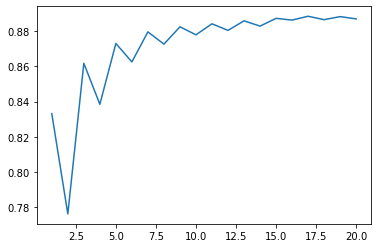

In [234]:
from sklearn.metrics import f1_score

preds = []

for k in list(range(1,21)):
    neigh_test = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    y_pred = neigh_test.predict(X_test)
    preds.append(f1_score(y_test, y_pred, pos_label = 0))
    
sns.lineplot(x = range(1,21), y = preds)

In [229]:
k = 12
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
y_pred = neigh.predict(X_test)
y_pred[:5]

array([0, 0, 0, 0, 0])

[[0.23356574 0.76643426]
 [0.0580587  0.9419413 ]]


<ipython-input-226-b5d55199f742>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-226-b5d55199f742>:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



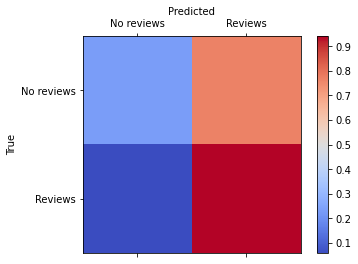

In [230]:
from sklearn.metrics import confusion_matrix

labels = [-1.0, 0.0]
tick_labels = ["No reviews", "Reviews"]

plot_confusion_matrix(labels, tick_labels, y_test, y_pred)

In [231]:
print(classification_report(y_test, y_pred, target_names=tick_labels))

              precision    recall  f1-score   support

  No reviews       0.51      0.23      0.32      2008
     Reviews       0.83      0.94      0.88      7768

    accuracy                           0.80      9776
   macro avg       0.67      0.59      0.60      9776
weighted avg       0.76      0.80      0.77      9776



In [232]:
from sklearn.linear_model import LogisticRegression

regr = LogisticRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

f1_score(y_test, y_pred, pos_label = 0)

0.8854786990380211

[[0.02191235 0.97808765]
 [0.0046344  0.9953656 ]]


<ipython-input-226-b5d55199f742>:14: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-226-b5d55199f742>:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



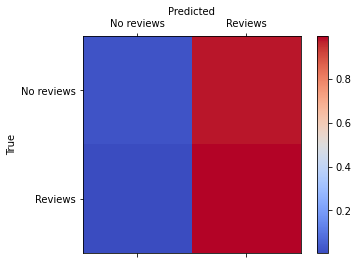

In [233]:
plot_confusion_matrix(labels, tick_labels, y_test, y_pred)

In [240]:
## hyperparameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 0.4, 0.6, 0.8, 1.0],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
    }
     

regr = LogisticRegression()

regr_best = GridSearchCV(regr, param_grid, cv=5,
                                  scoring="f1",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

regr_best.fit(X_train, y_train.reshape(-1, 1))
y_pred = regr_best.predict(y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\miach\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning:

One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]

C:\Users\miach\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning:

One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]

C:\Users\miach\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



ValueError: Expected 2D array, got 1D array instead:
array=[ 0  0  0 ...  0 -1  0].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [180]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

## notes to self

Try:
- SVM
- decision tree classifier
- feature trimming.
